In [1]:
%pip install qiskit qiskit-aer qiskit-ibm-provider


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /home/jovyan/.qbraid/environments/qiskit_f7xof1/pyenv/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.circuit.library import Initialize, XGate, ZGate
from qiskit.quantum_info import random_statevector

In [3]:
# Define helper functions
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a)
    qc.cx(a, b)

def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

def measure_and_send(qc, a, b):
    """Measures qubits a & b"""
    qc.barrier()
    qc.measure(a, 0)
    qc.measure(b, 1)

def bob_gates(qc, qubit, crz, crx):
    """
    Applies conditional gates to the qubit
    based on the classical registers' values.
    """
    with qc.if_test((crx, 1)):
        qc.x(qubit)

    with qc.if_test((crz, 1)):
        qc.z(qubit)

def new_bob_gates(qc, a, b, c):
    """For alternate formulation"""
    qc.cx(b, c)
    qc.cz(a, c)

<IPython.core.display.Latex object>

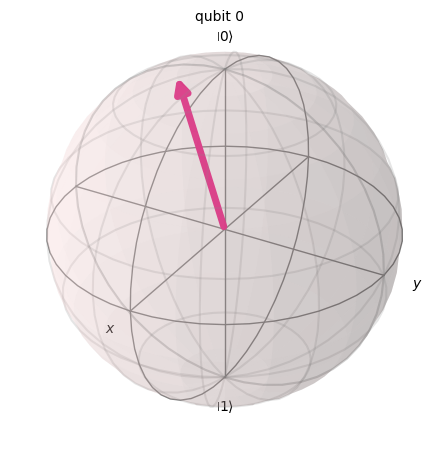

In [4]:
# Generate random state
psi = random_statevector(2)
display(array_to_latex(psi.data, prefix='\\psi ='))
plot_bloch_multivector(psi)

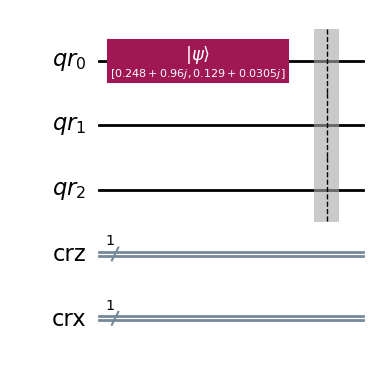

In [5]:
# Build teleportation circuit
qr = QuantumRegister(3, name='qr')
crz = ClassicalRegister(1, name='crz')
crx = ClassicalRegister(1, name='crx')
qc = QuantumCircuit(qr, crz, crx)

# Step 0: Initialize Alice's qubit
init_gate = Initialize(psi)
qc.append(init_gate, [0])
qc.barrier()
qc.draw('mpl')

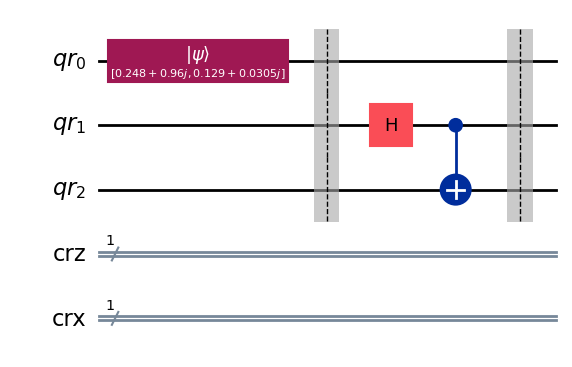

In [6]:
# Step 1: Create Bell pair
create_bell_pair(qc, 1, 2)
qc.barrier()
qc.draw('mpl')

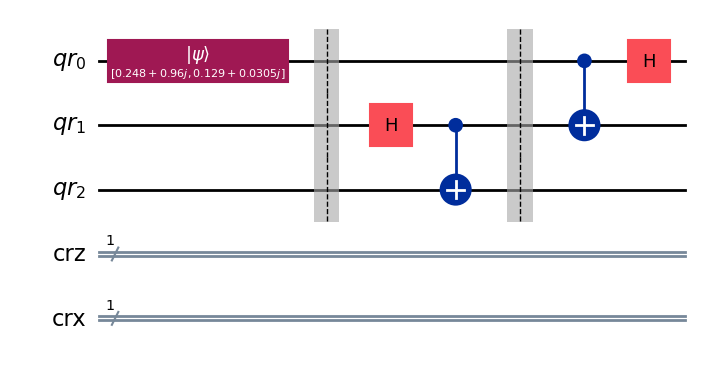

In [7]:
# Step 2: Alice's gates
alice_gates(qc, 0, 1)

qc.draw('mpl')

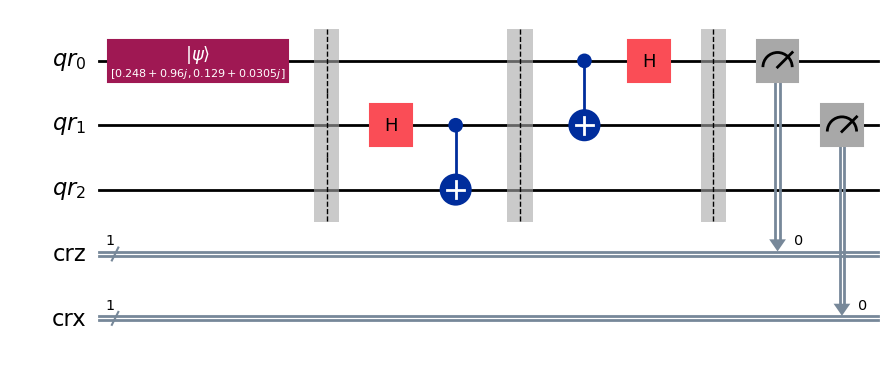

In [8]:
# Step 3: Measure and send
measure_and_send(qc, 0, 1)
qc.draw('mpl')

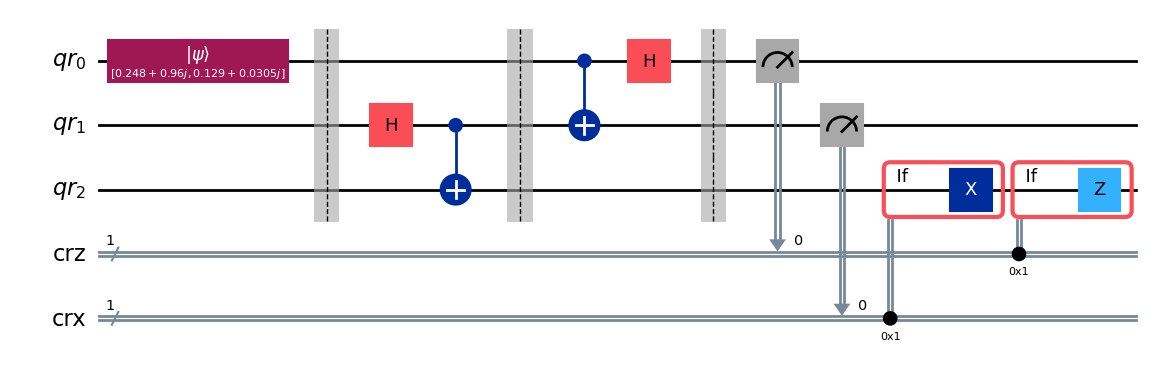

In [9]:
# Step 4: Bob applies gates
bob_gates(qc, 2, crz, crx)
qc.draw('mpl')

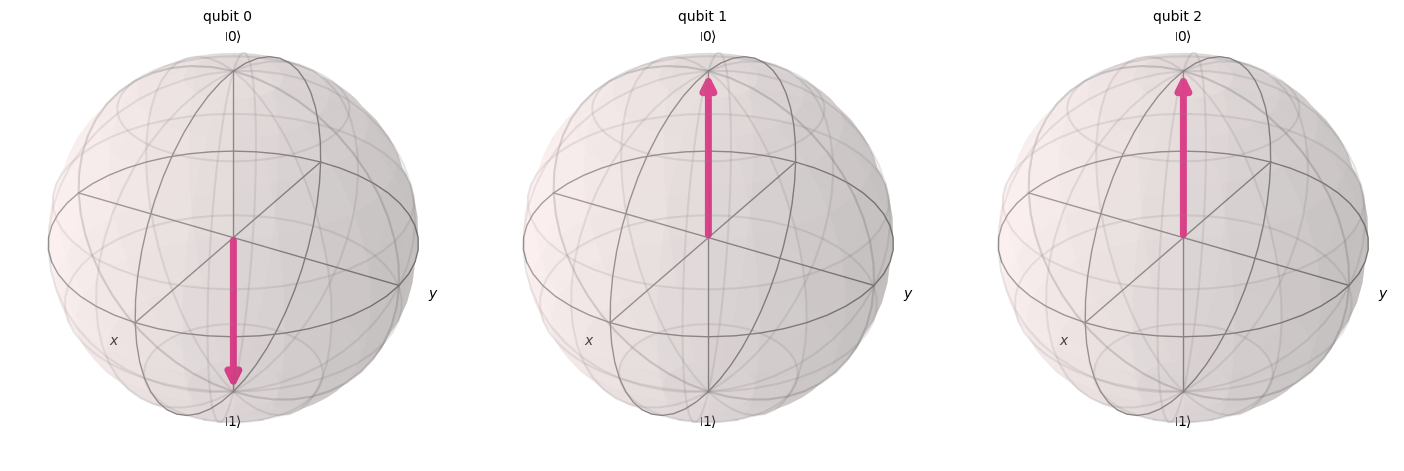

In [13]:
# Run on statevector simulator
sim = AerSimulator(method='statevector')
t_qc = transpile(qc, sim)
t_qc.save_statevector()
result = sim.run(t_qc).result()
out_vector = result.get_statevector()
plot_bloch_multivector(out_vector)

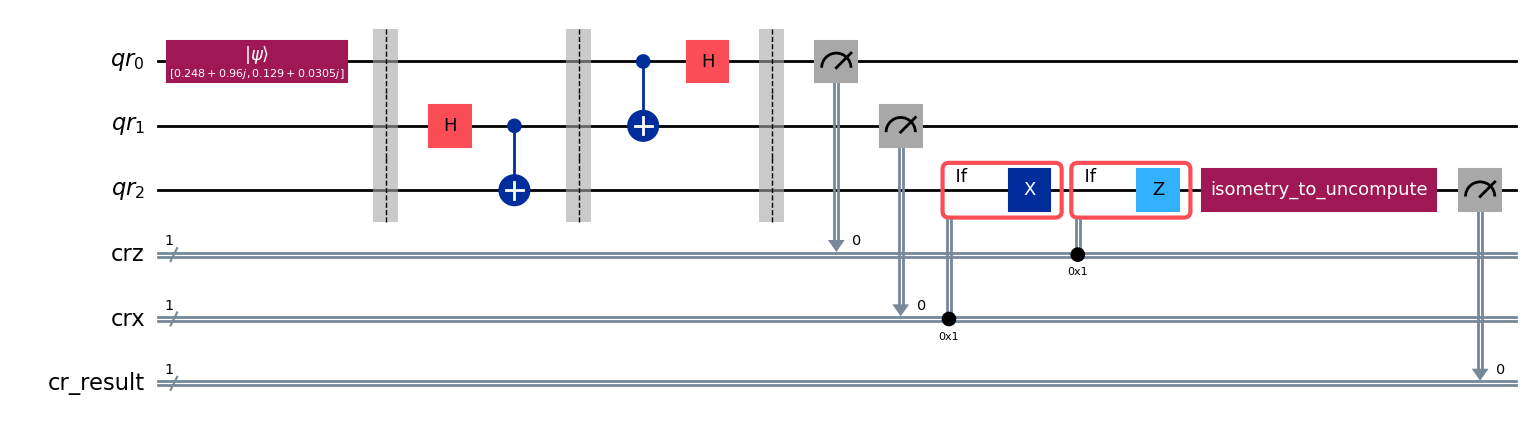

In [11]:
# Run on QASM simulator (to get measurement outcomes)
inverse_init_gate = init_gate.gates_to_uncompute()

qr = QuantumRegister(3, name='qr')
crz = ClassicalRegister(1, name='crz')
crx = ClassicalRegister(1, name='crx')
cr_result = ClassicalRegister(1, name='cr_result')
qc = QuantumCircuit(qr, crz, crx, cr_result)

qc.append(init_gate, [0])
qc.barrier()

create_bell_pair(qc, 1, 2)
qc.barrier()

alice_gates(qc, 0, 1)
measure_and_send(qc, 0, 1)
bob_gates(qc, 2, crz, crx)

qc.append(inverse_init_gate, [2])
qc.measure(2, cr_result)

qc.draw('mpl')

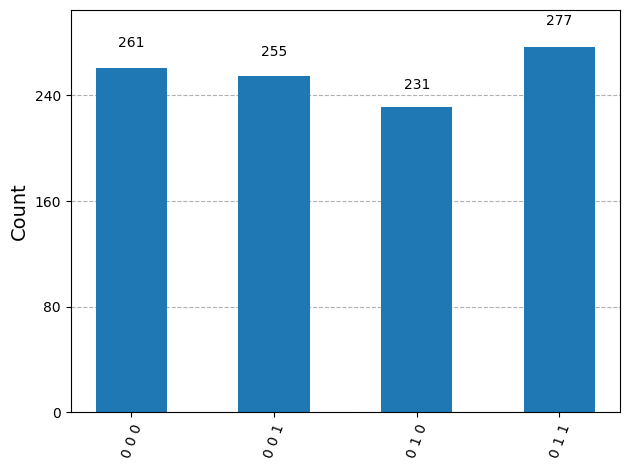

In [12]:
# Run on QASM simulator
sim = AerSimulator()
t_qc = transpile(qc, sim)
t_qc.save_statevector()
result = sim.run(t_qc, shots=1024).result()

counts = result.get_counts()
plot_histogram(counts)

In [14]:
print(result.get_counts())

{'0 0 1': 245, '0 0 0': 271, '0 1 0': 261, '0 1 1': 247}
